<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/With_MF_ML_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install rdkit
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from google.colab import drive
drive.mount('/content/drive')

# Silence some expected warnings
filterwarnings("ignore")

!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/test_mordred_phenol_scaled_reduced.csv
!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/train_mordred_phenol_scaled_reduced.csv
#!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/test_mordred_scaled_reduced.csv
#!wget https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/train_mordred_scaled_reduced.csv
!wget https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/master/models/train_test_datasets/test_mordred_scaled_reduced.csv
!wget https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/master/models/train_test_datasets/train_mordred_scaled_reduced.csv
!wget https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/my_dataframe.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-05-11 12:26:10--  https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/test_mordred_phenol_scaled_reduced.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘test_mordred_phenol_scaled_reduced.csv.1’

test_mordred_phenol     [ <=>                ]   1.09M  --.-KB/s    in 0.08s   

2025-05-11 12:26:10 (14.3 MB/s) - ‘test_mordred_phenol_scaled_reduced.csv.1’ saved [1139754]

--2025-05-11 12:26:10--  https://github.com/ManuelOtt-code/Project-DC/blob/master/models/train_test_datasets/train_mordred_phenol_scaled_reduced.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiti

In [14]:
def remove_semi_constant_features(df, semi_constant_threshold):
    """Removes columns from a Pandas DataFrame where 80% or more of the values are the same.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with the single-value columns removed.
    """

    cols_to_drop = []
    for col in df.columns:
        try:
            # Calculate the percentage of the most frequent value
            counts = df[col].value_counts(normalize=True)
            if counts.iloc[0] >= semi_constant_threshold:
                cols_to_drop.append(col)
        except (TypeError, IndexError):
            pass  # Handle cases where value_counts fails (e.g., mixed data types)

    return df.drop(columns=cols_to_drop)

def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df
def drop_high_correlation_columns(df, threshold=0.75):
    """Drops columns from a DataFrame that have a correlation above a specified threshold.

    Args:
        df: The input DataFrame.
        threshold: The correlation threshold above which columns are dropped.

    Returns:
        A new DataFrame with highly correlated columns removed.
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than 0.75
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features
    return df.drop(columns=to_drop)



In [21]:
USE_MORDRED = True  # Set to False to use Morgan fingerprints

if USE_MORDRED:
    # Load full Mordred descriptor dataset
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/all_mordred_unscaled.csv")
    df = remove_semi_constant_features(df,0.8)
    df = drop_non_numeric_columns(df)
    df = drop_high_correlation_columns(df, 0.75)
    # Remove exact duplicate columns
    df = df.T.drop_duplicates().T
    df = df.dropna(axis=1)
    X = df.drop("active", axis=1).to_numpy()
    y = df["active"].to_numpy()
else:
    # Load raw SMILES + activity
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/my_dataframe.csv")  # adjust path if needed

    # Morgan fingerprint generator
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

    # Function to convert SMILES to Morgan fingerprint
    def smiles_to_fp(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.nan
        return mfpgen.GetFingerprintAsNumPy(mol)

    # Apply it to generate numeric fingerprints
    df["fp"] = df["canonical_Smiles"].apply(smiles_to_fp)
    df = df[df["fp"].notna()]  # Drop rows where fingerprint failed

    X = np.vstack(df["fp"].to_numpy())
    y = df["active"].to_numpy()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 217 and the array at index 1 has size 206

In [16]:
# Define Preprocessing and Models

def get_model_pipeline(model_name):
    if model_name == 'RandomForest':
        model = RandomForestClassifier(class_weight='balanced', random_state=42)
    elif model_name == 'SVM':
        model = SVC(class_weight='balanced', probability=True, random_state=42)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
    elif model_name == 'NeuralNetwork':
        model = MLPClassifier(max_iter=1000, random_state=42)
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    return pipeline

In [17]:
#Hyperparameter Tuning with Cross-Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def perform_grid_search(pipeline, param_grid, X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search

In [18]:
# parameter grids for each model
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__max_features': ['sqrt', 'log2']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    'NeuralNetwork': {
        'classifier__hidden_layer_sizes': [(50,), (100,)],
        'classifier__alpha': [0.0001, 0.001],
        'classifier__learning_rate_init': [0.001, 0.01]
    }
}

In [19]:
#Model Evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, cohen_kappa_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def evaluate_model_with_cv(model, X, y, random_state=42):
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    metrics = {
        'accuracies': [], 'precisions': [], 'recalls': [],
        'f1_scores': [], 'auc_scores': [], 'kappas': []
    }

    plt.figure(figsize=(6, 5))

    for k, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        kappa = cohen_kappa_score(y_test, y_pred)

        metrics['accuracies'].append(acc)
        metrics['precisions'].append(prec)
        metrics['recalls'].append(rec)
        metrics['f1_scores'].append(f1)
        metrics['auc_scores'].append(auc)
        metrics['kappas'].append(kappa)

        # Custom ROC plot
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'Fold {k+1} (AUC = {auc:.2f})')

    # Final ROC plot formatting
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Across 10 Stratified Folds')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nEvaluation Metrics (10-fold Stratified CV):")
    for key, values in metrics.items():
        mean = np.mean(values)
        stderr = stats.sem(values)
        print(f"{key.capitalize():<12} Mean = {mean:.4f}, StdErr = {stderr:.4f}")

    return metrics



Training and evaluating RandomForest...


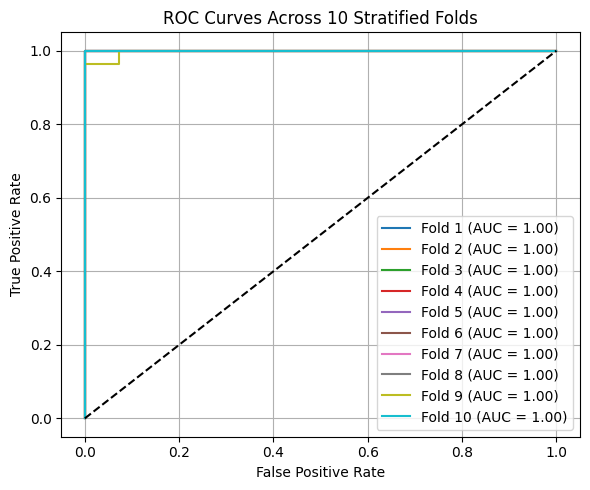


Evaluation Metrics (10-fold Stratified CV):
Accuracies   Mean = 0.9834, StdErr = 0.0062
Precisions   Mean = 0.9798, StdErr = 0.0089
Recalls      Mean = 0.9966, StdErr = 0.0034
F1_scores    Mean = 0.9878, StdErr = 0.0045
Auc_scores   Mean = 0.9997, StdErr = 0.0003
Kappas       Mean = 0.9617, StdErr = 0.0144

Training and evaluating SVM...


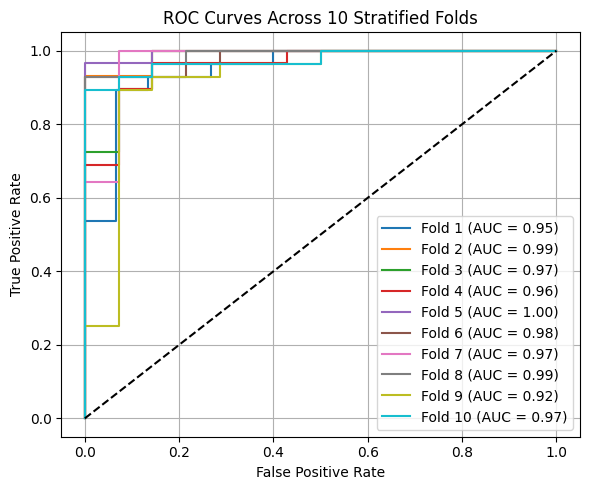


Evaluation Metrics (10-fold Stratified CV):
Accuracies   Mean = 0.9200, StdErr = 0.0063
Precisions   Mean = 0.9446, StdErr = 0.0100
Recalls      Mean = 0.9367, StdErr = 0.0102
F1_scores    Mean = 0.9399, StdErr = 0.0048
Auc_scores   Mean = 0.9706, StdErr = 0.0071
Kappas       Mean = 0.8201, StdErr = 0.0144

Training and evaluating LogisticRegression...


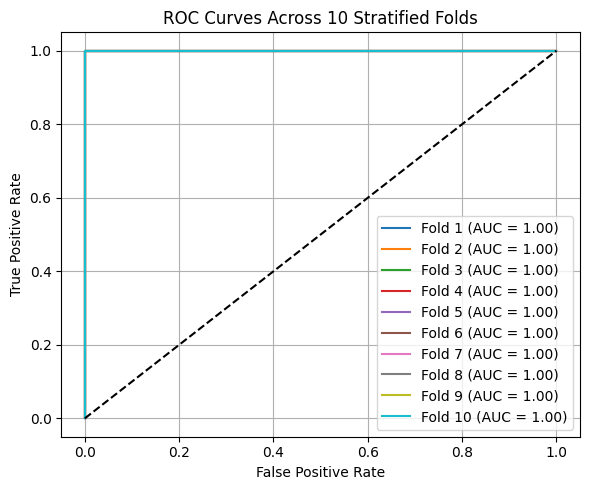


Evaluation Metrics (10-fold Stratified CV):
Accuracies   Mean = 0.8637, StdErr = 0.0188
Precisions   Mean = 1.0000, StdErr = 0.0000
Recalls      Mean = 0.7957, StdErr = 0.0285
F1_scores    Mean = 0.8837, StdErr = 0.0178
Auc_scores   Mean = 1.0000, StdErr = 0.0000
Kappas       Mean = 0.7253, StdErr = 0.0348

Training and evaluating NeuralNetwork...


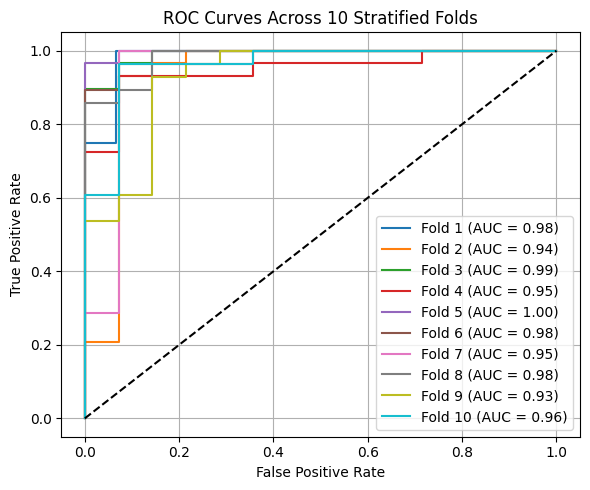


Evaluation Metrics (10-fold Stratified CV):
Accuracies   Mean = 0.9293, StdErr = 0.0071
Precisions   Mean = 0.9425, StdErr = 0.0101
Recalls      Mean = 0.9543, StdErr = 0.0105
F1_scores    Mean = 0.9476, StdErr = 0.0052
Auc_scores   Mean = 0.9661, StdErr = 0.0076
Kappas       Mean = 0.8390, StdErr = 0.0166


In [22]:
# loop through each model, perform grid search, and evaluate
for model_name in ['RandomForest', 'SVM', 'LogisticRegression', 'NeuralNetwork']:
    print(f"\nTraining and evaluating {model_name}...")

    pipeline = get_model_pipeline(model_name)
    param_grid = param_grids[model_name]

    grid_search = perform_grid_search(pipeline, param_grid, X, y)
    best_model = grid_search.best_estimator_

    evaluate_model_with_cv(best_model, X, y)


In [ ]:
print("Active class ratio:", np.mean(y))

Active class ratio: 0.668235294117647


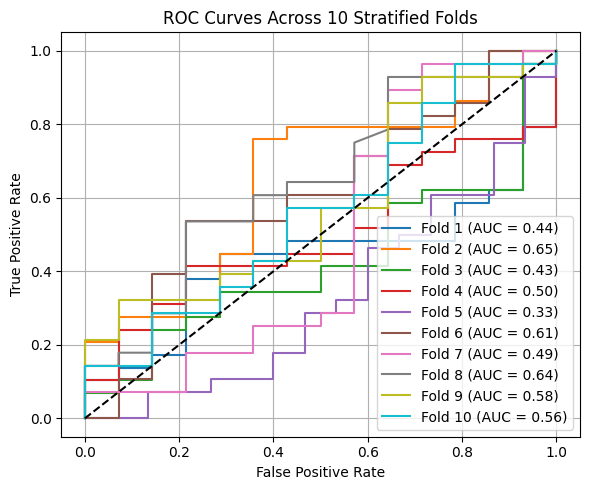


Evaluation Metrics (10-fold Stratified CV):
Accuracies   Mean = 0.5815, StdErr = 0.0257
Precisions   Mean = 0.6823, StdErr = 0.0200
Recalls      Mean = 0.7074, StdErr = 0.0299
F1_scores    Mean = 0.6916, StdErr = 0.0201
Auc_scores   Mean = 0.5237, StdErr = 0.0328
Kappas       Mean = 0.0311, StdErr = 0.0642


{'accuracies': [0.4883720930232558,
  0.6976744186046512,
  0.5581395348837209,
  0.5581395348837209,
  0.46511627906976744,
  0.5952380952380952,
  0.5952380952380952,
  0.7142857142857143,
  0.6190476190476191,
  0.5238095238095238],
 'precisions': [0.6060606060606061,
  0.7857142857142857,
  0.6388888888888888,
  0.6666666666666666,
  0.5806451612903226,
  0.7391304347826086,
  0.7037037037037037,
  0.7352941176470589,
  0.7,
  0.6666666666666666],
 'recalls': [0.6896551724137931,
  0.7586206896551724,
  0.7931034482758621,
  0.6896551724137931,
  0.6428571428571429,
  0.6071428571428571,
  0.6785714285714286,
  0.8928571428571429,
  0.75,
  0.5714285714285714],
 'f1_scores': [0.6451612903225806,
  0.7719298245614035,
  0.7076923076923077,
  0.6779661016949152,
  0.6101694915254238,
  0.6666666666666666,
  0.6909090909090909,
  0.8064516129032258,
  0.7241379310344828,
  0.6153846153846154],
 'auc_scores': [np.float64(0.43596059113300495),
  np.float64(0.6477832512315271),
  np.floa

In [ ]:
np.random.shuffle(y)
evaluate_model_with_cv(best_model, X, y)
